In [ ]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from sklearn.model_selection import train_test_split

from modules.experiment_pipeline import (
    ExperimentConfig,
    run_experiment_pipeline,
    results_to_dataframe,
    get_model,
    get_best_model,
    get_confusion_matrix,
    get_predictions,
)

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../data/X_final.pkl', 'rb') as f:
    X = pickle.load(f)
with open('../data/labels.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

X shape: (39100, 50029)
y shape: (39100,)
Class distribution: [17903 21197]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 29325
Test size: 9775


In [ ]:
# Load the original dataframe once
true_df = pd.read_parquet('../data/data_cleaned_text.parquet')

# Get test indices for mapping back to original data
_, test_indices = train_test_split(
    np.arange(len(y)), 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

def get_model_by_name(model_name: str):
    """Get model and its name from saved joblib files."""
    name_map = {
        "linear": "linearsvc",
        "rbf": "rbf_svc", 
        "poly": "poly_svc"
    }
    full_name = name_map.get(model_name.lower(), model_name)
    model = joblib.load(f'../models/trained/{full_name}_best.joblib')
    return model, full_name


def misclassification_details(model_name: str):
    """Show misclassification statistics for a model."""
    model, full_name = get_model_by_name(model_name)
    y_pred = model.predict(X_test)
    
    misclassified_mask = y_pred != y_test
    
    print(f"=== Misclassification Details: {full_name} ===\n")
    print(f"Total samples:       {len(y_test)}")
    print(f"Correct:             {sum(~misclassified_mask)}")
    print(f"Misclassified:       {sum(misclassified_mask)}")
    print(f"Accuracy:            {sum(~misclassified_mask) / len(y_test):.4f}")
    print(f"\n  - False Positives (Fake → Real): {sum((y_pred == 1) & (y_test == 0))}")
    print(f"  - False Negatives (Real → Fake): {sum((y_pred == 0) & (y_test == 1))}")
    
    return y_pred, misclassified_mask


def show_misclassified_samples(model_name: str, n_samples: int = 10):
    """Display misclassified samples with their text."""
    model, full_name = get_model_by_name(model_name)
    y_pred = model.predict(X_test)
    
    misclassified_mask = y_pred != y_test
    misclassified_indices = np.where(misclassified_mask)[0]
    
    # Limit to n_samples
    show_indices = misclassified_indices[:n_samples]
    original_indices = test_indices[show_indices]
    
    print(f"=== Misclassified Samples: {full_name} (showing {len(show_indices)}/{len(misclassified_indices)}) ===\n")
    
    for i, (test_idx, orig_idx) in enumerate(zip(show_indices, original_indices)):
        print(f"--- Sample {i+1} ---")
        print(f"True Label: {'Real' if y_test[test_idx] == 1 else 'Fake'}")
        print(f"Predicted:  {'Real' if y_pred[test_idx] == 1 else 'Fake'}")
        print(f"Title: {true_df.iloc[orig_idx]['title'][:200]}...")
        print(f"Text: {true_df.iloc[orig_idx]['text'][:500]}...")
        print()


def margin_analysis(model_name: str):
    """Analyze samples within the margin (close to decision boundary)."""
    model, full_name = get_model_by_name(model_name)
    
    # Get decision scores
    decision_scores = model.decision_function(X_test)
    
    print(f"=== Margin Analysis: {full_name} ===\n")
    print(f"Decision score range: [{decision_scores.min():.4f}, {decision_scores.max():.4f}]")
    print(f"Mean absolute score:  {np.abs(decision_scores).mean():.4f}")
    print()
    
    # Samples within margin
    margin_mask = np.abs(decision_scores) <= 1
    margin_indices = np.where(margin_mask)[0]
    
    print(f"Samples within margin (|score| <= 1): {len(margin_indices)}")
    print(f"Samples very close to boundary (|score| <= 0.5): {sum(np.abs(decision_scores) <= 0.5)}")
    print()
    
    # Additional thresholds
    thresholds = [0.1, 0.25, 2.0, 5.0]
    for thresh in thresholds:
        count = sum(np.abs(decision_scores) <= thresh)
        pct = count / len(decision_scores) * 100
        print(f"Samples within |score| <= {thresh}: {count} ({pct:.2f}%)")
    
    return decision_scores, margin_indices


def show_boundary_samples(model_name: str, n_samples: int = 10):
    """Display samples closest to the decision boundary."""
    model, full_name = get_model_by_name(model_name)
    y_pred = model.predict(X_test)
    decision_scores = model.decision_function(X_test)
    
    # Get indices that are close to boundary
    closest_indices = np.argsort(np.abs(decision_scores))[:n_samples]
    
    print(f"=== Top {n_samples} Samples Closest to Decision Boundary: {full_name} ===\n")
    
    for i, test_idx in enumerate(closest_indices):
        orig_idx = test_indices[test_idx]
        print(f"--- Sample {i+1} ---")
        print(f"Decision Score: {decision_scores[test_idx]:.4f}")
        print(f"True Label:     {'Real' if y_test[test_idx] == 1 else 'Fake'}")
        print(f"Predicted:      {'Real' if y_pred[test_idx] == 1 else 'Fake'}")
        print(f"Correct:        {'✓' if y_pred[test_idx] == y_test[test_idx] else '✗'}")
        print(f"Title: {true_df.iloc[orig_idx]['title'][:150]}")
        print(f"Text: {true_df.iloc[orig_idx]['text'][:300]}...")
        print()


def visualize_decision_scores(model_name: str, figsize: tuple = (12, 5), clip_percentile: float = 1.0):
    """Visualize decision score distribution and margins."""
    model, full_name = get_model_by_name(model_name)
    decision_scores = model.decision_function(X_test)
    y_pred = model.predict(X_test)
    
    lower_bound = np.percentile(decision_scores, clip_percentile)
    upper_bound = np.percentile(decision_scores, 100 - clip_percentile)
    padding = (upper_bound - lower_bound) * 0.1
    xlim = (lower_bound - padding, upper_bound + padding)
    
    scores_in_range = decision_scores[(decision_scores >= xlim[0]) & (decision_scores <= xlim[1])]
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Decision score distribution by true class
    ax1 = axes[0]
    fake_scores = decision_scores[y_test == 0]
    real_scores = decision_scores[y_test == 1]
    
    fake_clipped = np.clip(fake_scores, xlim[0], xlim[1])
    real_clipped = np.clip(real_scores, xlim[0], xlim[1])
    
    ax1.hist(fake_clipped, bins=50, alpha=0.6, label='Fake (True)', color='red', range=xlim)
    ax1.hist(real_clipped, bins=50, alpha=0.6, label='Real (True)', color='blue', range=xlim)
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision Boundary')
    ax1.axvline(x=-1, color='gray', linestyle=':', alpha=0.7, label='Margin')
    ax1.axvline(x=1, color='gray', linestyle=':', alpha=0.7)
    ax1.set_xlim(xlim)
    ax1.set_xlabel('Decision Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{full_name}: Decision Scores by True Class')
    ax1.legend()
    
    # Plot 2: Decision score distribution by prediction correctness
    ax2 = axes[1]
    correct_mask = y_pred == y_test
    correct_clipped = np.clip(decision_scores[correct_mask], xlim[0], xlim[1])
    wrong_clipped = np.clip(decision_scores[~correct_mask], xlim[0], xlim[1])
    
    ax2.hist(correct_clipped, bins=50, alpha=0.6, label='Correct', color='green', range=xlim)
    if sum(~correct_mask) > 0:
        ax2.hist(wrong_clipped, bins=50, alpha=0.6, label='Misclassified', color='orange', range=xlim)
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision Boundary')
    ax2.axvline(x=-1, color='gray', linestyle=':', alpha=0.7)
    ax2.axvline(x=1, color='gray', linestyle=':', alpha=0.7)
    ax2.set_xlim(xlim)
    ax2.set_xlabel('Decision Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{full_name}: Correct vs Misclassified')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\n=== Decision Score Summary: {full_name} ===")
    print(f"Fake samples - Mean score: {decision_scores[y_test == 0].mean():.4f}")
    print(f"Real samples - Mean score: {decision_scores[y_test == 1].mean():.4f}")
    if sum(~correct_mask) > 0:
        print(f"Misclassified - Mean |score|: {np.abs(decision_scores[~correct_mask]).mean():.4f}")
    else:
        print(f"Misclassified - None!")
    print(f"Correct - Mean |score|: {np.abs(decision_scores[correct_mask]).mean():.4f}")
    
    # Report outliers
    n_outliers = sum((decision_scores < xlim[0]) | (decision_scores > xlim[1]))
    if n_outliers > 0:
        print(f"\nNote: {n_outliers} outlier(s) outside plot range [{xlim[0]:.2f}, {xlim[1]:.2f}]")
        print(f"Full range: [{decision_scores.min():.2f}, {decision_scores.max():.2f}]")


def full_model_analysis(model_name: str, n_misclassified: int = 5, n_boundary: int = 5):
    """Run all analyses for a single model."""
    print("=" * 60)
    print(f"FULL ANALYSIS: {model_name.upper()}")
    print("=" * 60)
    print()
    
    # 1. Misclassification details
    misclassification_details(model_name)
    print()
    
    # 2. Margin analysis
    margin_analysis(model_name)
    print()
    
    # 3. Visualize decision scores
    visualize_decision_scores(model_name)
    print()
    
    # 4. Show misclassified samples
    show_misclassified_samples(model_name, n_samples=n_misclassified)
    
    # 5. Show boundary samples
    show_boundary_samples(model_name, n_samples=n_boundary)

FULL ANALYSIS: POLY

=== Misclassification Details: poly_svc ===

Total samples:       9775
Correct:             9775
Misclassified:       0
Accuracy:            1.0000

  - False Positives (Fake → Real): 0
  - False Negatives (Real → Fake): 0

=== Margin Analysis: poly_svc ===

Decision score range: [-140.0555, 1.3007]
Mean absolute score:  1.1622

Samples within margin (|score| <= 1): 342
Samples very close to boundary (|score| <= 0.5): 0

Samples within |score| <= 0.1: 0 (0.00%)
Samples within |score| <= 0.25: 0 (0.00%)
Samples within |score| <= 2.0: 9764 (99.89%)
Samples within |score| <= 5.0: 9774 (99.99%)



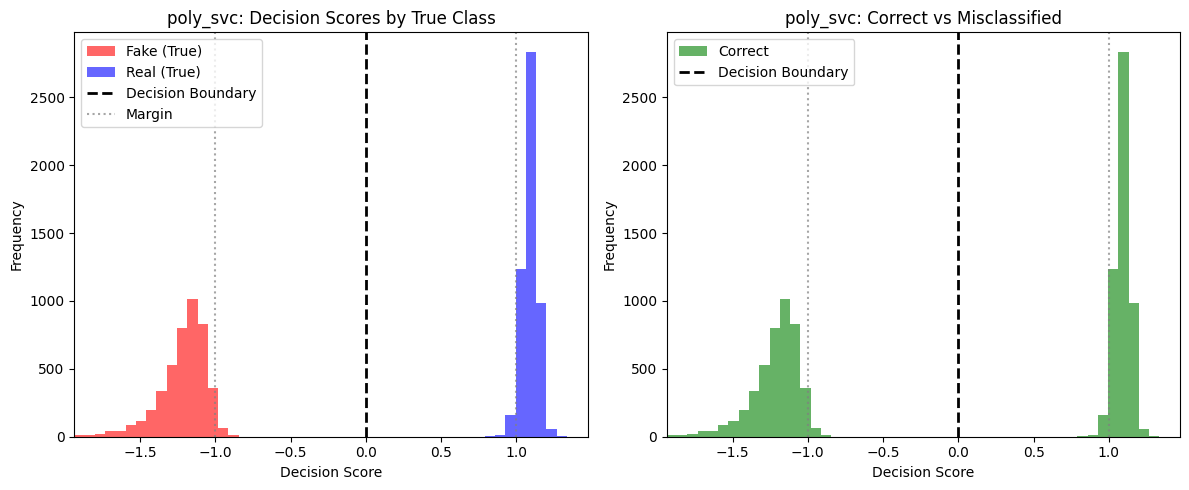


=== Decision Score Summary: poly_svc ===
Fake samples - Mean score: -1.2468
Real samples - Mean score: 1.0908
Misclassified - None!
Correct - Mean |score|: 1.1622

Note: 13 outlier(s) outside plot range [-1.94, 1.47]
Full range: [-140.06, 1.30]

=== Misclassified Samples: poly_svc (showing 0/0) ===

=== Top 5 Samples Closest to Decision Boundary: poly_svc ===

--- Sample 1 ---
Decision Score: -0.8297
True Label:     Fake
Predicted:      Fake
Correct:        ✓
Title: (Video) Angry Latino Activist: “Ultimately, it doesn’t matter if we’re undocumented.”
Text: Anti-Trump Activist says what everyone on the left thinks  His comment is at the 1:52 mark: ...

--- Sample 2 ---
Decision Score: 0.8496
True Label:     Real
Predicted:      Real
Correct:        ✓
Title: Anti-Zuma MP quits South Africa's 'corrupt' ANC
Text: African National Congress (ANC) MP Makhosi Khoza, a strident critic of scandal-plagued President Jacob Zuma, quit South Africa s ruling party on Thursday, labeling Nelson Mandela

In [23]:
full_model_analysis("poly")

In [ ]:
import shap

def shap_analysis(model_name: str, n_background: int = 50, n_boundary_samples: int = 5):
    """
    Perform SHAP analysis on samples close to decision boundary.
    
    Args:
        model_name: "linear", "rbf", or "poly"
        n_background: Number of background samples for SHAP explainer
        n_boundary_samples: Number of boundary samples to analyze (3-5 recommended)
    """
    model, full_name = get_model_by_name(model_name)
    
    print(f"=== SHAP Analysis: {full_name} ===\n")
    
    decision_scores = model.decision_function(X_test)
    
    boundary_indices = np.argsort(np.abs(decision_scores))[:n_boundary_samples]
    
    np.random.seed(42)
    background_idx = np.random.choice(X_train.shape[0], size=n_background, replace=False)
    X_background = X_train[background_idx]
    
    X_boundary = X_test[boundary_indices]
    
    print(f"Using {n_background} background samples")
    print(f"Analyzing {n_boundary_samples} samples closest to decision boundary\n")
    
    with open('../data/artifacts/vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    feature_names = list(vectorizer.get_feature_names_out())
    
    num_features = [
        'repost_count', 'text_exclamation_count', 'text_capital_ratio', 
        'text_avg_sentence_length', 'title_exclamation_count', 'title_capital_ratio',
        'text_sentiment_polarity', 'text_sentiment_subjectivity',
        'title_sentiment_polarity', 'title_sentiment_subjectivity',
        'text_emotion_score', 'title_emotion_score',
        'month_sin', 'month_cos', 'day_sin', 'day_cos'
    ]
    feature_names.extend(num_features)
    
    cat_features = [
        'subject_WorldNews', 
        'text_emotion_anger', 'text_emotion_disgust', 'text_emotion_fear', 
        'text_emotion_joy', 'text_emotion_neutral', 'text_emotion_sadness', 'text_emotion_surprise',
        'title_emotion_anger', 'title_emotion_disgust', 'title_emotion_fear', 
        'title_emotion_joy', 'title_emotion_neutral', 'title_emotion_sadness', 'title_emotion_surprise'
    ]
    feature_names.extend(cat_features)
    
    n_features = X_boundary.shape[1]
    if len(feature_names) < n_features:
        feature_names.extend([f'feature_{i}' for i in range(len(feature_names), n_features)])
    feature_names = feature_names[:n_features]
    
    if model_name.lower() == "linear":
        print("Using LinearExplainer for linear kernel...")
        explainer = shap.LinearExplainer(model, X_background, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_boundary)
        expected_value = explainer.expected_value
        X_for_plot = X_boundary.toarray() if hasattr(X_boundary, 'toarray') else X_boundary
    else:
        print("Using KernelExplainer for non-linear kernel...")
        print("Summarizing background data with kmeans (10 clusters)...")
        
        X_background_dense = X_background.toarray()
        X_background_summary = shap.kmeans(X_background_dense, 10)
        
        explainer = shap.KernelExplainer(model.decision_function, X_background_summary)
        
        X_for_plot = X_boundary.toarray()
        
        print("Calculating SHAP values (this may take a few minutes)...")
        shap_values = explainer.shap_values(X_for_plot, nsamples=100)
        expected_value = explainer.expected_value
    
    print("\n--- SHAP Summary Plot (Top Features Across Boundary Samples) ---")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_for_plot, 
                      feature_names=feature_names, max_display=15, show=False)
    plt.tight_layout()
    plt.show()
    
    y_pred = model.predict(X_test)
    
    for i, test_idx in enumerate(boundary_indices):
        orig_idx = test_indices[test_idx]
        
        print(f"\n{'='*60}")
        print(f"Sample {i+1}: Decision Score = {decision_scores[test_idx]:.4f}")
        print(f"True: {'Real' if y_test[test_idx] == 1 else 'Fake'} | "
              f"Predicted: {'Real' if y_pred[test_idx] == 1 else 'Fake'} | "
              f"{'✓ Correct' if y_pred[test_idx] == y_test[test_idx] else '✗ Wrong'}")
        print(f"Title: {true_df.iloc[orig_idx]['title'][:100]}...")
        print('='*60)
        
        sample_shap = shap_values[i]
        top_indices = np.argsort(np.abs(sample_shap))[-10:][::-1]
        
        print("\nTop 10 Features Influencing This Prediction:")
        print("-" * 50)
        print(f"{'Feature':<35} {'SHAP Value':>12} {'Direction':<10}")
        print("-" * 50)
        
        for idx in top_indices:
            shap_val = sample_shap[idx]
            direction = "→ Real" if shap_val > 0 else "→ Fake"
            print(f"{feature_names[idx]:<35} {shap_val:>12.4f} {direction:<10}")
        
        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(
            shap.Explanation(
                values=sample_shap, 
                base_values=expected_value,
                data=X_for_plot[i],
                feature_names=feature_names
            ),
            max_display=10,
            show=False
        )
        plt.title(f"Sample {i+1}: {'Real' if y_test[test_idx] == 1 else 'Fake'} "
                  f"(Predicted: {'Real' if y_pred[test_idx] == 1 else 'Fake'})")
        plt.tight_layout()
        plt.show()
    
    return shap_values, boundary_indices, feature_names

=== SHAP Analysis: linearsvc ===

Using 100 background samples
Analyzing 5 samples closest to decision boundary

Using LinearExplainer for linear kernel...

--- SHAP Summary Plot (Top Features Across Boundary Samples) ---


/opt/miniconda3/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_6192/305072856.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_for_plot,


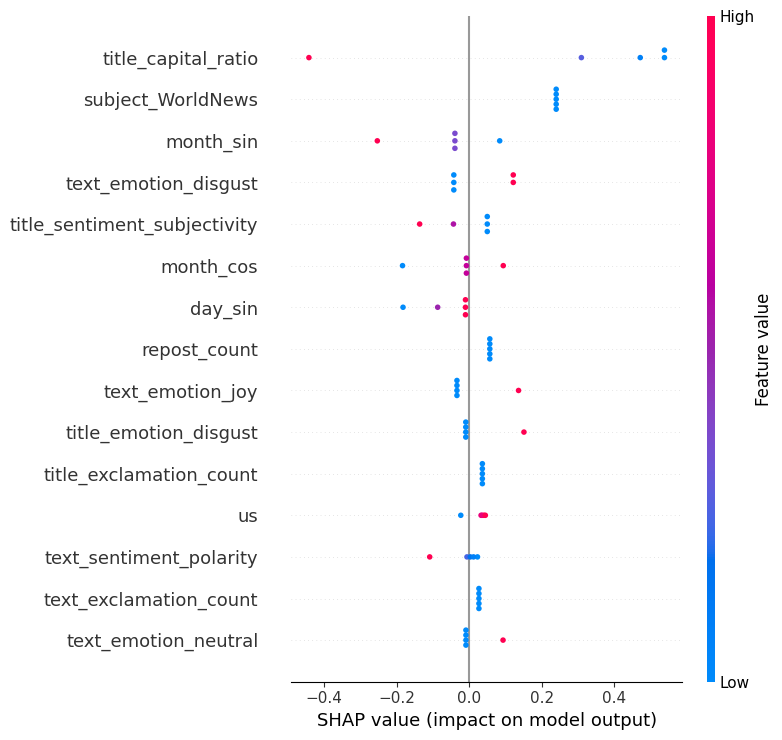


Sample 1: Decision Score = -0.0040
True: Fake | Predicted: Fake | ✓ Correct
Title: Jimmy Kimmel’s Hysterical Take On The Republican Debate [Video]...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.4716 → Real    
subject_WorldNews                         0.2398 → Real    
title_emotion_disgust                     0.1508 → Real    
title_sentiment_subjectivity             -0.1368 → Fake    
text_emotion_joy                          0.1359 → Real    
text_sentiment_polarity                  -0.1091 → Fake    
republican                                0.0726 → Real    
repost_count                              0.0567 → Real    
jimmy                                    -0.0492 → Fake    
text_emotion_disgust                     -0.0426 → Fake    


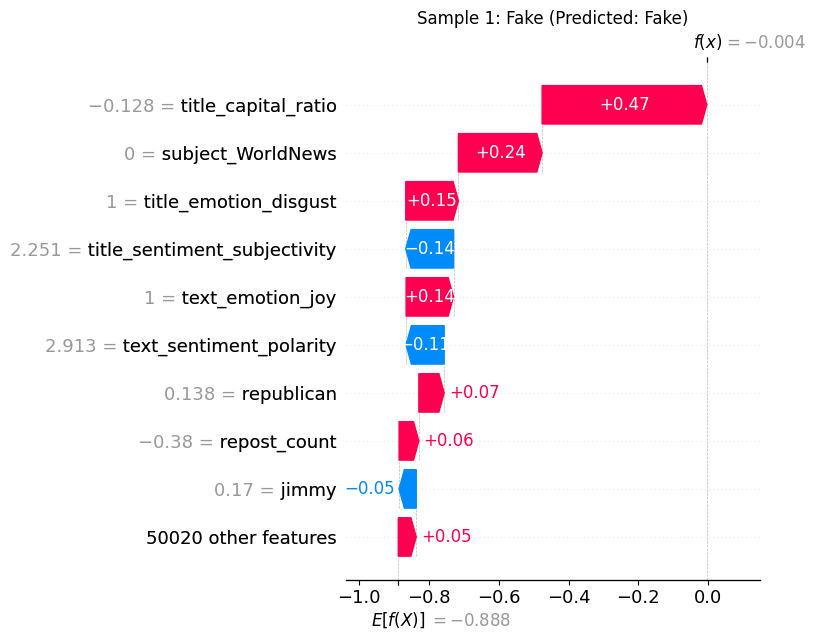


Sample 2: Decision Score = 0.0221
True: Real | Predicted: Real | ✓ Correct
Title: Trump attacks FBI on leakers of Russia reports: 'FIND NOW'...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                      -0.4423 → Fake    
month_sin                                -0.2536 → Fake    
subject_WorldNews                         0.2398 → Real    
text_emotion_disgust                      0.1214 → Real    
month_cos                                 0.0938 → Real    
day_sin                                  -0.0871 → Fake    
repost_count                              0.0567 → Real    
day_cos                                   0.0539 → Real    
on friday                                 0.0498 → Real    
title_sentiment_subjectivity              0.0497 → Real    


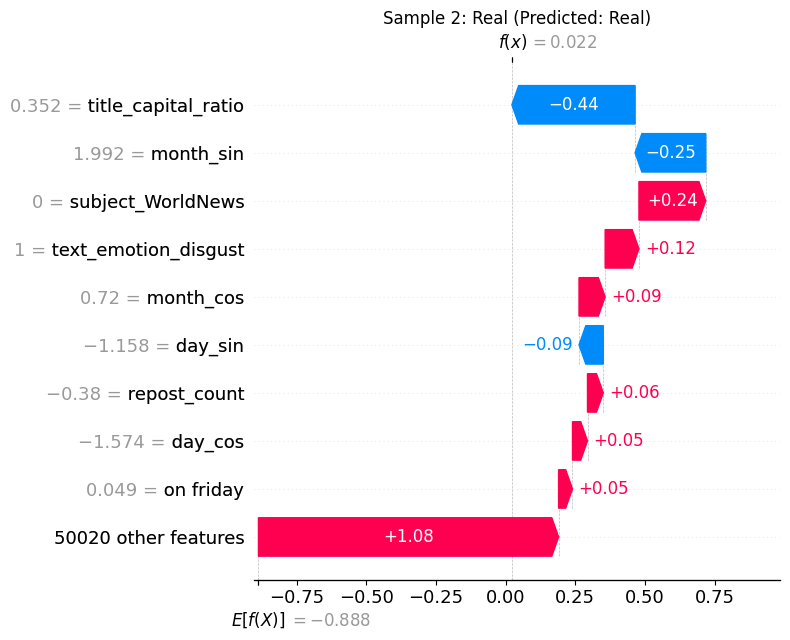


Sample 3: Decision Score = 0.0490
True: Fake | Predicted: Real | ✗ Wrong
Title: Why John McCain Will Never Vote to Repeal and Replace Obamacare...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.3092 → Real    
subject_WorldNews                         0.2398 → Real    
text_emotion_disgust                      0.1214 → Real    
repost_count                              0.0567 → Real    
title_sentiment_subjectivity              0.0497 → Real    
us                                        0.0443 → Real    
read more                                -0.0434 → Fake    
month_sin                                -0.0396 → Fake    
text_avg_sentence_length                  0.0366 → Real    
title_exclamation_count                   0.0361 → Real    


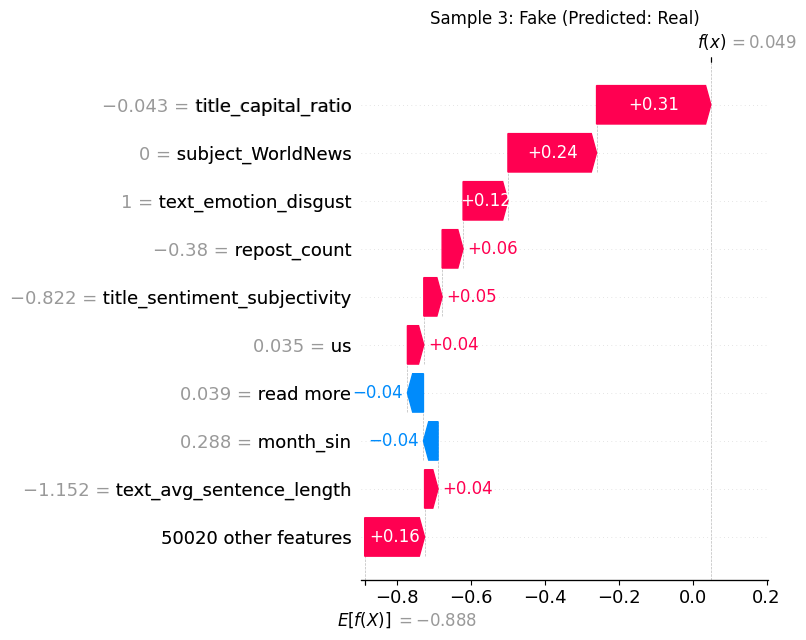


Sample 4: Decision Score = -0.0516
True: Real | Predicted: Fake | ✗ Wrong
Title: U.S. Women's Open must leave Trump National, says Burk...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.5384 → Real    
subject_WorldNews                         0.2398 → Real    
month_cos                                -0.1841 → Fake    
day_sin                                  -0.1827 → Fake    
month_sin                                 0.0840 → Real    
repost_count                              0.0567 → Real    
title_sentiment_subjectivity             -0.0436 → Fake    
text_emotion_disgust                     -0.0426 → Fake    
us                                        0.0403 → Real    
title_exclamation_count                   0.0361 → Real    


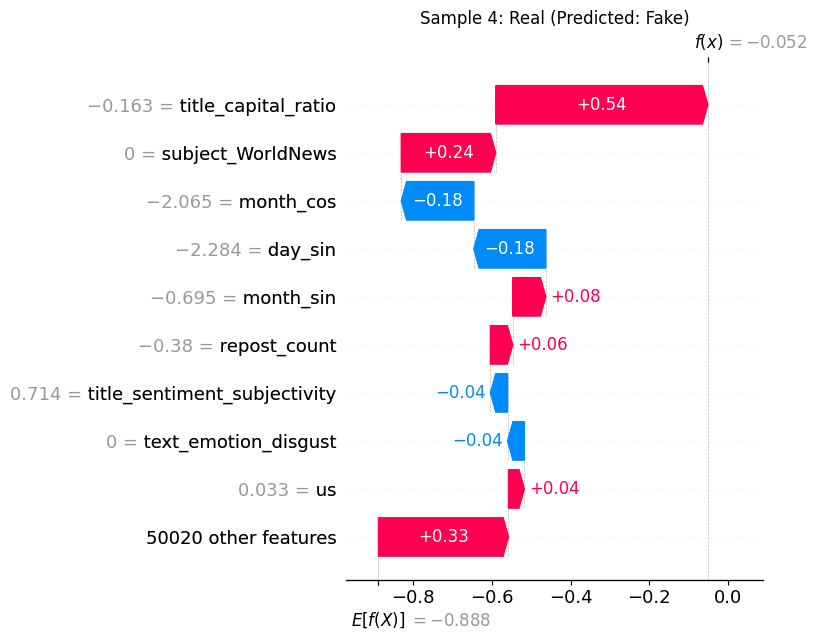


Sample 5: Decision Score = -0.0560
True: Fake | Predicted: Fake | ✓ Correct
Title: Cities Across America Are Replacing Columbus Day With Indigenous People’s Day...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
title_capital_ratio                       0.5384 → Real    
subject_WorldNews                         0.2398 → Real    
text_emotion_neutral                      0.0932 → Real    
repost_count                              0.0567 → Real    
title_sentiment_subjectivity              0.0497 → Real    
text_emotion_disgust                     -0.0426 → Fake    
monday                                    0.0419 → Real    
month_sin                                -0.0396 → Fake    
t                                        -0.0370 → Fake    
title_exclamation_count                   0.0361 → Real    


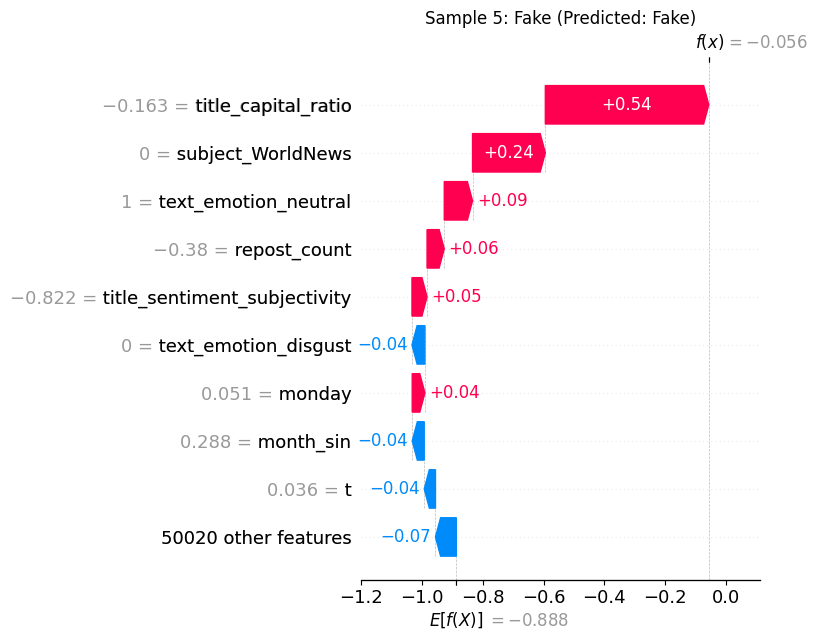

In [8]:
shap_values, indices, features = shap_analysis("linear", n_background=100, n_boundary_samples=5)


=== SHAP Analysis: rbf_svc ===

Using 30 background samples
Analyzing 3 samples closest to decision boundary

Using KernelExplainer for non-linear kernel...
Summarizing background data with kmeans (10 clusters)...
Calculating SHAP values (this may take a few minutes)...


100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


--- SHAP Summary Plot (Top Features Across Boundary Samples) ---



/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_6192/305072856.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_for_plot,


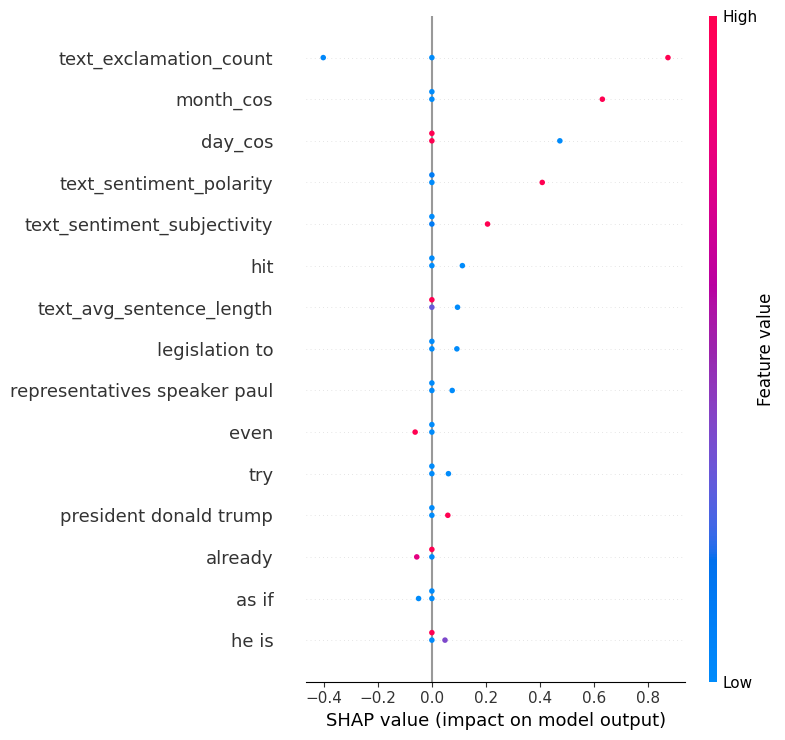


Sample 1: Decision Score = 0.0274
True: Fake | Predicted: Real | ✗ Wrong
Title:  Fed Up Republicans Threaten Third Party Option If Trump Is The Nominee...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
text_exclamation_count                    0.8748 → Real    
text_avg_sentence_length                  0.0950 → Real    
legislation to                            0.0926 → Real    
even                                     -0.0620 → Fake    
as if                                    -0.0492 → Fake    
expected                                 -0.0383 → Fake    
emergency                                 0.0373 → Real    
spare                                    -0.0287 → Fake    
woman in the                              0.0241 → Real    
about it                                  0.0078 → Real    


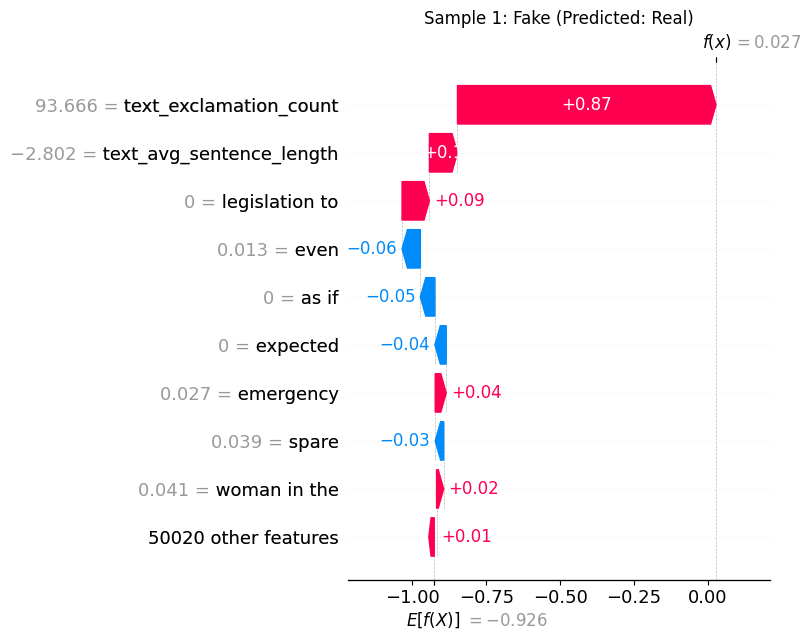


Sample 2: Decision Score = -0.0412
True: Real | Predicted: Fake | ✗ Wrong
Title: Trump on Twitter (Dec 8) - Hanukkah, Roy Moore, Wells Fargo...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
month_cos                                 0.6317 → Real    
day_cos                                   0.4742 → Real    
text_exclamation_count                   -0.4025 → Fake    
representatives speaker paul              0.0753 → Real    
president donald trump                    0.0591 → Real    
already                                  -0.0560 → Fake    
he is                                     0.0486 → Real    
? hillary                                 0.0353 → Real    
they                                      0.0187 → Real    
faster                                    0.0004 → Real    


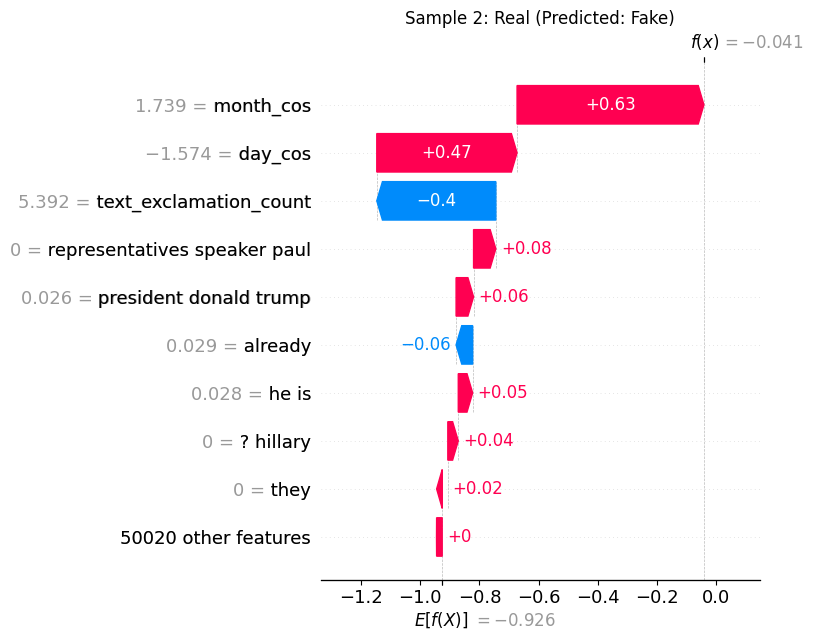


Sample 3: Decision Score = -0.0502
True: Fake | Predicted: Fake | ✓ Correct
Title: KELLYANNE CONWAY: “I’m not a sore winner, I’m a winner! My guy is a winner! He’s the next president!...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
text_sentiment_polarity                   0.4089 → Real    
text_sentiment_subjectivity               0.2063 → Real    
hit                                       0.1130 → Real    
try                                       0.0613 → Real    
did not                                   0.0413 → Real    
texas                                     0.0200 → Real    
trillion                                  0.0152 → Real    
of the                                   -0.0131 → Fake    
<NUM> <NUM>                               0.0115 → Real    
personally                                0.0115 → Real    


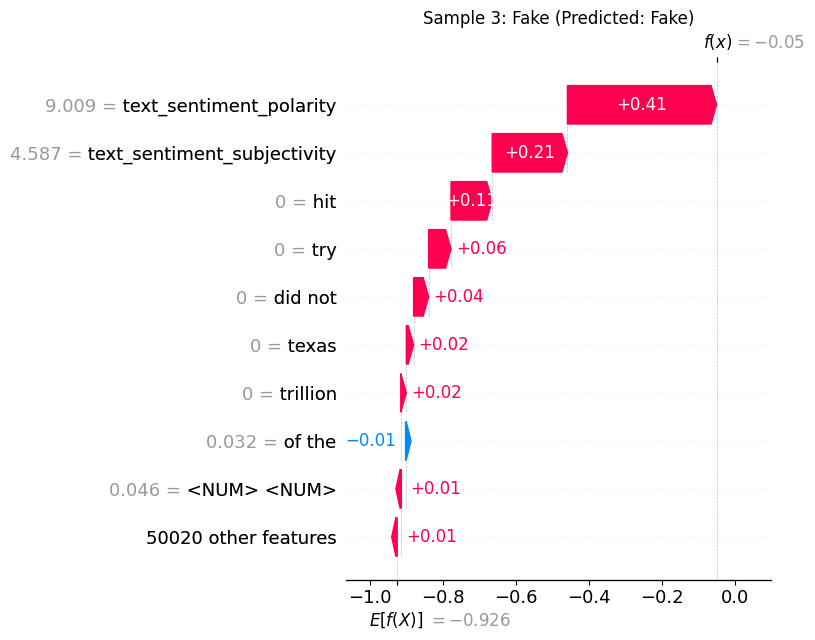

In [9]:
shap_values, indices, features = shap_analysis("rbf", n_background=30, n_boundary_samples=3)

=== SHAP Analysis: poly_svc ===

Using 30 background samples
Analyzing 3 samples closest to decision boundary

Using KernelExplainer for non-linear kernel...
Summarizing background data with kmeans (10 clusters)...
Calculating SHAP values (this may take a few minutes)...


 33%|███▎      | 1/3 [00:01<00:03,  1.94s/it]/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.441e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


--- SHAP Summary Plot (Top Features Across Boundary Samples) ---



/var/folders/8f/6znkn6r55qj5dgt5vxxlvwjm0000gn/T/ipykernel_6192/305072856.py:93: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_for_plot,


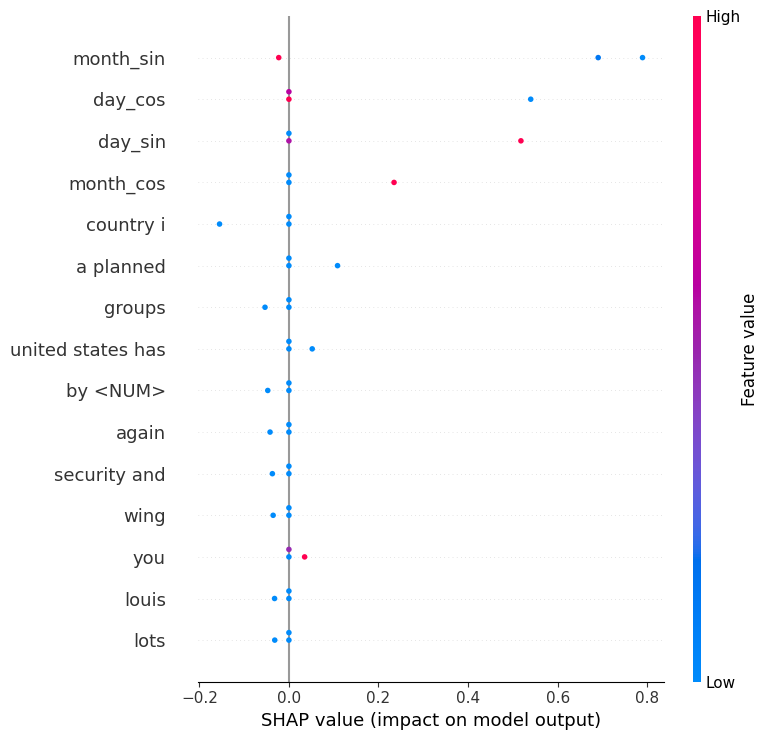


Sample 1: Decision Score = -0.8297
True: Fake | Predicted: Fake | ✓ Correct
Title: (Video) Angry Latino Activist: “Ultimately, it doesn’t matter if we’re undocumented.”...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
by <NUM>                                 -0.0472 → Fake    
again                                    -0.0421 → Fake    
security and                             -0.0369 → Fake    
louis                                    -0.0320 → Fake    
lots                                     -0.0316 → Fake    
end of                                   -0.0275 → Fake    
month_sin                                -0.0227 → Fake    
a woman                                  -0.0224 → Fake    
house will                               -0.0171 → Fake    
of our                                   -0.0024 → Fake    


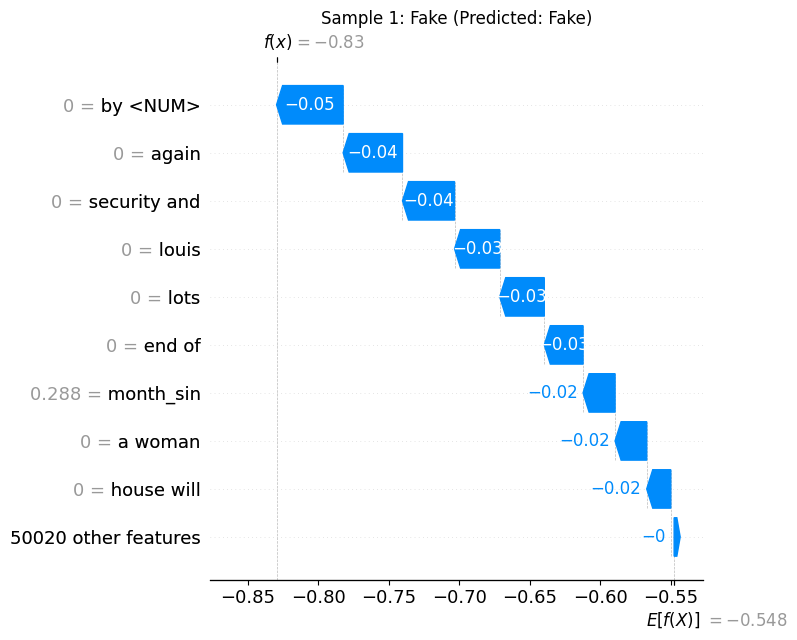


Sample 2: Decision Score = 0.8496
True: Real | Predicted: Real | ✓ Correct
Title: Anti-Zuma MP quits South Africa's 'corrupt' ANC...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
month_sin                                 0.7896 → Real    
day_cos                                   0.5399 → Real    
united states has                         0.0520 → Real    
wing                                     -0.0352 → Fake    
than                                      0.0304 → Real    
campaign                                  0.0251 → Real    
corrupt                                  -0.0192 → Fake    
<NUM> <NUM> so                            0.0161 → Real    
ryan                                     -0.0013 → Fake    
guarded                                   0.0000 → Fake    


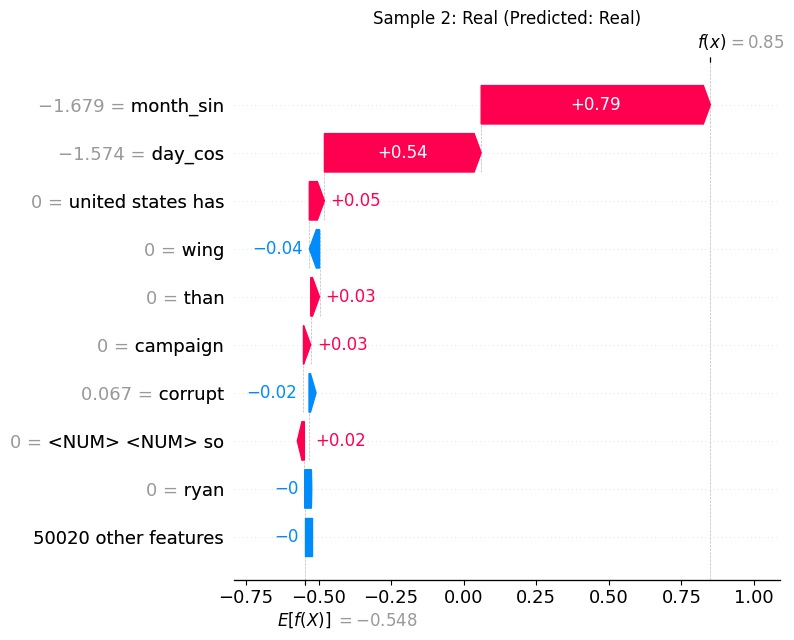


Sample 3: Decision Score = 0.8497
True: Real | Predicted: Real | ✓ Correct
Title: INTERNET: Living with the Great Firewall of China...

Top 10 Features Influencing This Prediction:
--------------------------------------------------
Feature                               SHAP Value Direction 
--------------------------------------------------
month_sin                                 0.6906 → Real    
day_sin                                   0.5180 → Real    
month_cos                                 0.2348 → Real    
country i                                -0.1549 → Fake    
a planned                                 0.1086 → Real    
groups                                   -0.0534 → Fake    
you                                       0.0351 → Real    
the country s                             0.0244 → Real    
i want to                                -0.0057 → Fake    
guarded                                   0.0000 → Fake    


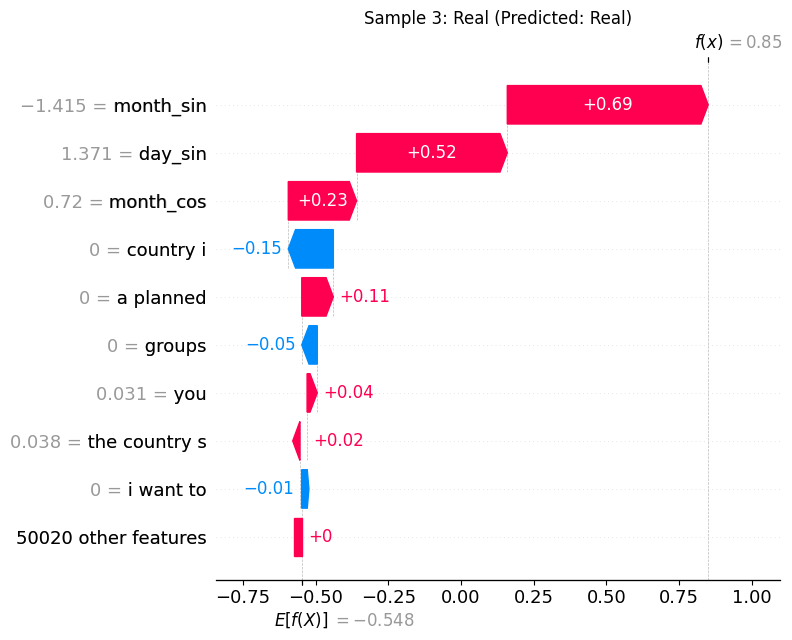

In [10]:
shap_values, indices, features = shap_analysis("poly", n_background=30, n_boundary_samples=3)